In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

Website scraper to create data

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                        
                        for headline, article in zip(soup.find_all('div', class_=["news-card-title news-right-box"]),
                                                     soup.find_all('div', class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
    
    df = pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head()

,news_headline,news_article,news_category
0,Star Wars actor Mark deletes Facebook account;...,"Actor Mark Hamill, known for playing 'Luke Sky...",technology
1,1 lakh small traders to protest against Jeff B...,"The Confederation of All India Traders (CAIT),...",technology
2,Elon Musk says Tesla cars will soon talk to pe...,Electric carmaker Tesla's CEO Elon Musk has sa...,technology
3,Pichai asked to act against 'bloatware' on And...,Over 50 privacy groups have asked Google and A...,technology
4,People find pictures of their dead loved ones ...,Hundreds of people are finding photos of their...,technology


In [4]:
news_df.news_category.value_counts()

technology    25
world         25
sports        24
Name: news_category, dtype: int64

In [5]:
import spacy
import en_core_web_sm
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata

nlp = en_core_web_sm.load()
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# Want to keep negative stop words for sentiment analysis
stopword_list.remove('no')
stopword_list.remove('not')

In [6]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>text text text</h2></html>')

'text text text'

In [7]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('some accented letters â î or ô')

'some accented letters a i or o'

In [8]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("y'all I've don't I'd we're")

'you all I have do not I would we are'

In [9]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("S0me sp3ci@l c#@4@c|3rs *&)@&)@#&", remove_digits=True)

'Sme spcil ccrs '

In [10]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("The 22 teams who’ll be watching the weekend slate of games in their living rooms were decidedly more pass happy, gaining 30.8 percent of their yards on the ground")

'the 22 team who will be watch the weekend slate of game in their living room be decidedly more pass happy , gain 30.8 percent of their yard on the ground'

In [11]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

remove_stopwords("The 22 teams who’ll be watching the weekend slate of games in their living rooms were decidedly more pass happy, gaining 30.8 percent of their yards on the ground")

'22 teams ’ watching weekend slate games living rooms decidedly pass happy , gaining 30.8 percent yards ground'

In [12]:
def normalize_corpus(corpus, html_stripping=True, accented_char_removal=True, contraction_expansion=True, 
                    text_lower_case=True, text_lemmatization=True, special_char_removal=True, stopword_removal=True,
                    remove_digits=True):
    normalized_corpus = []
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions
        if contraction_expansion:
            doc = expand_contractions(doc)
        # turn into lowercase
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and/or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
        # remove extra whitespaces
        doc = re.sub(' _', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
    
    return normalized_corpus

In [13]:
# combine news headline and article text into one doc
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': '1 lakh small traders to protest against Jeff Bezos during his stay in India. The Confederation of All India Traders (CAIT), which represents around 7 crore retailers, said it will protest across 300 cities during Amazon CEO Jeff Bezos\' stay in India. "We expect to mobilise at least 1 lakh traders in the protests," CAIT said. Bezos will visit India next week for a company event in Delhi and potential meetings with government officials.',
 'clean_text': 'lakh small trader protest jeff bezos stay india confederation india trader cait represent around crore retailer say protest across city amazon ceo jeff bezos stay india expect mobilise least lakh trader protest cait say bezos visit india next week company event delhi potential meeting government official'}

**Part of Speech Tagging**

In [14]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aksin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
# pre-process, but don't lowercase or lemmatize to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, text_lemmatization=False, special_char_removal=False)

# demo for POS tagging
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

# POS tagging with spacy
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
df_spacy_pos_tagged = pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
df_nltk_pos_tagged = pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])


In [16]:
df_spacy_pos_tagged.head(10)

,Word,POS tag,Tag type
0,1,CD,NUM
1,lakh,JJ,ADJ
2,small,JJ,ADJ
3,traders,NNS,NOUN
4,to,TO,PART
5,protest,VB,VERB
6,against,IN,ADP
7,Jeff,NNP,PROPN
8,Bezos,NNP,PROPN
9,during,IN,ADP


In [17]:
df_nltk_pos_tagged.head(10)

,Word,POS tag
0,1,CD
1,lakh,JJS
2,small,JJ
3,traders,NNS
4,to,TO
5,protest,VB
6,against,IN
7,Jeff,NNP
8,Bezos,NNP
9,during,IN


**Shallow Parsing (Chunking)**

In [18]:
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\aksin\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

In [19]:
# using nltk conll2000 corpus to train the shallow parser model
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:]

print(len(train_data), len(test_data))
print(train_data[2])

10900 48
(S
  But/CC
  (NP analysts/NNS)
  (VP reckon/VBP)
  (NP underlying/VBG support/NN)
  (PP for/IN)
  (NP sterling/NN)
  (VP has/VBZ been/VBN eroded/VBN)
  (PP by/IN)
  (NP the/DT chancellor/NN)
  (NP 's/POS failure/NN)
  (VP to/TO announce/VB)
  (NP any/DT new/JJ policy/NN measures/NNS)
  (PP in/IN)
  (NP his/PRP$ Mansion/NNP House/NNP speech/NN)
  (NP last/JJ Thursday/NNP)
  ./.)


In [20]:
# tree2conlltags returns a tuple for each token consisting of token, tag, chunk tag
# conlltags2tree returns parse tree from these token triples
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[2])
wtc

[('But', 'CC', 'O'),
 ('analysts', 'NNS', 'B-NP'),
 ('reckon', 'VBP', 'B-VP'),
 ('underlying', 'VBG', 'B-NP'),
 ('support', 'NN', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('been', 'VBN', 'I-VP'),
 ('eroded', 'VBN', 'I-VP'),
 ('by', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('chancellor', 'NN', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('failure', 'NN', 'I-NP'),
 ('to', 'TO', 'B-VP'),
 ('announce', 'VB', 'I-VP'),
 ('any', 'DT', 'B-NP'),
 ('new', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('measures', 'NNS', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('his', 'PRP$', 'B-NP'),
 ('Mansion', 'NNP', 'I-NP'),
 ('House', 'NNP', 'I-NP'),
 ('speech', 'NN', 'I-NP'),
 ('last', 'JJ', 'B-NP'),
 ('Thursday', 'NNP', 'I-NP'),
 ('.', '.', 'O')]

> The chunk tags use the IOB format, i.e., Inside, Outside, Beginning. Inside and Beginning are self evident. Outside indicates that the token does not belong to any chunk

In [21]:
# extract POS and chunk tags from sentences with chunked annotations
def conll_tags_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]

# train multiple taggers with backoff taggers (e.g., unigram and bigram taggers)
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

In [22]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# chunker class
class NGramTagChunker(ChunkParserI):
    def __init__(self, train_sentences, tagger_classes=[UnigramTagger, BigramTagger]):
        train_sent_tags = conll_tags_chunks(train_sentences)
        self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)
    
    def parse(self, tagged_sentence):
        if not tagged_sentence:
            return None
        pos_tags = [tag for word, tag in tagged_sentence]
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
        wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                       in zip(tagged_sentence, chunk_tags)]
        return conlltags2tree(wpc_tags)
    
# train chunker model
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))
        

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [23]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP 1/CD lakh/JJS small/JJ traders/NNS)
  (VP to/TO protest/VB)
  (PP against/IN)
  (NP Jeff/NNP Bezos/NNP)
  (PP during/IN)
  (NP his/PRP$ stay/NN)
  (PP in/IN)
  (NP India/NNP))


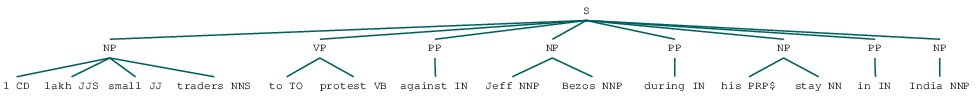

In [24]:
from IPython.display import display

os.environ['PATH'] = os.environ['PATH'] + ";C:\\Program Files\\gs\\gs9.50\\bin\\"
display(chunk_tree)

**Constituency Parsing**

In [25]:
java_path = r'C:\Program Files\Java\jdk1.8.0_221\bin\java.exe'
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='C:/Users/aksin/Projects/sentimentanalysis/stanford-parser-full-2018-10-17/stanford-parser.jar', 
                     path_to_models_jar='C:/Users/aksin/Projects/sentimentanalysis/stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar')
result = list(scp.raw_parse(sentence))
print(result[0])

C:\Users\aksin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  import sys


(ROOT
  (VP
    (LST (LS 1))
    (VB lakh)
    (NP (JJ small) (NNS traders))
    (S
      (VP
        (TO to)
        (VP
          (VB protest)
          (PP (IN against) (NP (NNP Jeff) (NNPS Bezos)))
          (PP
            (IN during)
            (NP
              (NP (PRP$ his) (NN stay))
              (PP (IN in) (NP (NNP India))))))))))


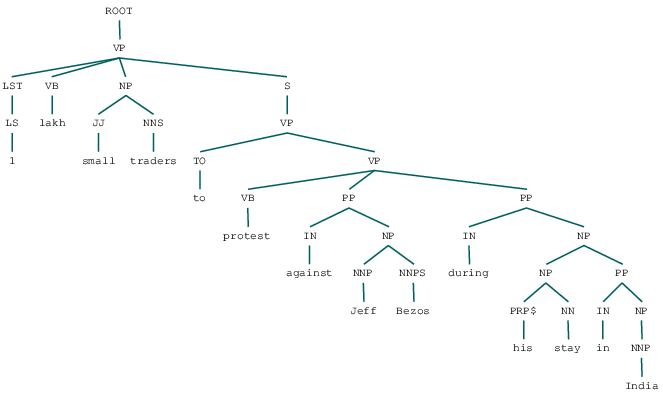

In [26]:
from IPython.display import display
display(result[0])

**Dependency Parsing**

In [27]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n-------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_,
                                  w_type = token.dep_,
                                  left=[t.orth_ for t in token.lefts],
                                  right=[t.orth_ for t in token.rights]))

[]<---1[nummod]--->[]
-------
[]<---lakh[det]--->[]
-------
[]<---small[amod]--->[]
-------
['1', 'lakh', 'small']<---traders[nsubj]--->[]
-------
[]<---to[aux]--->[]
-------
['traders', 'to']<---protest[ROOT]--->['against', 'during']
-------
[]<---against[prep]--->['Bezos']
-------
[]<---Jeff[compound]--->[]
-------
['Jeff']<---Bezos[pobj]--->[]
-------
[]<---during[prep]--->['stay']
-------
[]<---his[poss]--->[]
-------
['his']<---stay[pobj]--->['in']
-------
[]<---in[prep]--->['India']
-------
[]<---India[pobj]--->[]
-------


In [28]:
# Using spacy
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, options={'distance': 120, 'arrow_stroke': 2, 'arrow_width': 5})

C:\Users\aksin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  """


(lakh
  1
  (traders small)
  (protest to (Bezos against Jeff) (stay during his (India in))))


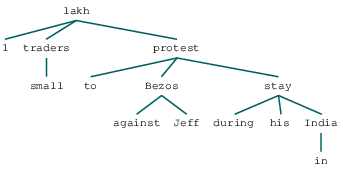

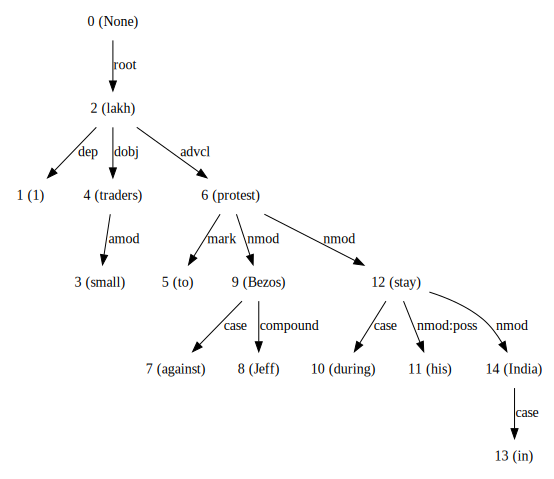

In [29]:
# Using nltk StanfordDependencyParser
from nltk.parse.stanford import StanfordDependencyParser

scp = StanfordDependencyParser(path_to_jar='C:/Users/aksin/Projects/sentimentanalysis/stanford-parser-full-2018-10-17/stanford-parser.jar', 
                     path_to_models_jar='C:/Users/aksin/Projects/sentimentanalysis/stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar')

result = list(scp.raw_parse(sentence))

# print the dependency tree
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

# visualize raw dependency tree
from IPython.display import display
display(dep_tree)

# visualize annotated dependency tree
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

from graphviz import Source
dep_tree_dot_repr = [parse for parse in result][0].to_dot()
source = Source(dep_tree_dot_repr, filename="dep_tree", format="png")
source

**Named Entity Recognition**

In [30]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

# print named entities in an article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(1, 'CARDINAL'), (Jeff, 'PERSON'), (Bezos, 'PERSON'), (India, 'GPE'), (CAIT, 'ORG'), (around, 'CARDINAL'), (7, 'CARDINAL'), (300, 'CARDINAL'), (Amazon, 'ORG'), (Jeff, 'PERSON'), (Bezos, 'PERSON'), (', 'PERSON'), (India, 'GPE'), (at, 'CARDINAL'), (least, 'CARDINAL'), (1, 'CARDINAL'), (CAIT, 'ORG'), (Bezos, 'PERSON'), (India, 'GPE'), (next, 'DATE'), (week, 'DATE'), (Delhi, 'GPE')]


In [31]:
# identify the most frequently named entities in the corpus
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

df_entity = pd.DataFrame(named_entities, columns=['Entity Name', 'Entity Type'])
df_entity.head(10)

,Entity Name,Entity Type
0,Mark,PERSON
1,Facebook,ORG
2,Zuckerberg,GPE
3,Mark Hamill,PERSON
4,Luke Skywalker Star Wars,PERSON
5,Monday,DATE
6,Facebook,ORG
7,Facebook,PRODUCT
8,Mark Zuckerberg,PERSON
9,Facebook,ORG


In [32]:
# get the top named entities
top_entities = (df_entity.groupby(by=['Entity Name', 'Entity Type']) \
                    .size() \
                    .sort_values(ascending=False) \
                    .reset_index().rename(columns={0: 'Frequency'}))
top_entities.T.iloc[:, :15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,China,India,Australian,Google,Sunday,two,Iranian,Virat Kohli,Team India,England,Monday,Instagram,Jasprit Bumrah,US,Iran
Entity Type,GPE,GPE,NORP,ORG,DATE,CARDINAL,NORP,PERSON,ORG,GPE,DATE,ORG,PERSON,GPE,GPE
Frequency,12,10,10,8,8,7,6,6,6,5,5,5,5,5,5


In [33]:
# get the top named entities
top_entities = (df_entity.groupby(by=['Entity Type']) \
                   .size() \
                   .sort_values(ascending=False) \
                   .reset_index().rename(columns={0: 'Frequency'}))
top_entities.T.iloc[:, :15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,PERSON,GPE,DATE,CARDINAL,NORP,QUANTITY,PRODUCT,ORDINAL,EVENT,LOC,FAC,WORK_OF_ART,TIME,PERCENT
Frequency,146,140,97,74,62,52,8,7,6,6,5,5,5,4,1


In [34]:
from nltk.tag import StanfordNERTagger

java_path = r'C:\Program Files\Java\jdk1.8.0_221\bin\java.exe'
os.environ['JAVAHOME'] = java_path

sn = StanfordNERTagger('C:/Users/aksin/Projects/sentimentanalysis/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz', 
                     path_to_jar='C:/Users/aksin/Projects/sentimentanalysis/stanford-ner-2018-10-16/stanford-ner.jar')

# tag named entities
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

# extract all named entities
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

df_entity = pd.DataFrame(named_entities, columns=['Entity Name', 'Entity Type'])
df_entity.head()

,Entity Name,Entity Type
0,Mark,PERSON
1,Facebook,ORGANIZATION
2,Mark Hamill,PERSON
3,Luke Skywalker,PERSON
4,Facebook,ORGANIZATION


In [35]:
# view top entities and types
top_entities = (df_entity.groupby(by=['Entity Name', 'Entity Type']) \
                    .size() \
                    .sort_values(ascending=False) \
                    .reset_index().rename(columns={0: 'Frequency'}))

top_entities.head(15)


,Entity Name,Entity Type,Frequency
0,Google,ORGANIZATION,16
1,India,LOCATION,13
2,China,LOCATION,9
3,Facebook,ORGANIZATION,8
4,BCCI,ORGANIZATION,8
5,Australia,LOCATION,6
6,Iran,LOCATION,5
7,US,LOCATION,5
8,Instagram,ORGANIZATION,5
9,Harry,PERSON,4


In [36]:

top_entities = (df_entity.groupby(by=['Entity Type']) \
                   .size() \
                   .sort_values(ascending=False) \
                   .reset_index().rename(columns={0: 'Frequency'}))
top_entities.head()


,Entity Type,Frequency
0,PERSON,144
1,ORGANIZATION,106
2,LOCATION,96


*SENTIMENT ANALYSIS*

>**Sentiment Analysis with AFINN**

In [44]:
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                          else 'neutral' 
                          for score in sentiment_scores]

# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                             
                        count  mean       std   min  25%  50%    75%   max
news_category                                                             
sports                   24.0  5.00  6.909351  -4.0  0.0  3.0  10.25  24.0
technology               25.0 -1.04  4.382541 -10.0 -3.0  0.0   2.00   5.0
world                    25.0 -3.68  6.799020 -21.0 -6.0 -4.0   0.00   8.0

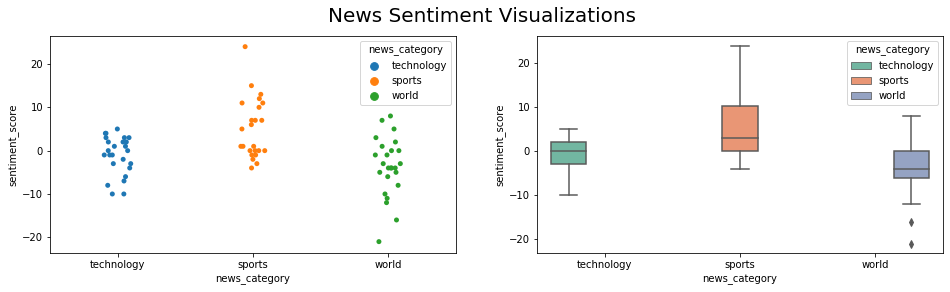

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sp = sns.stripplot(x='news_category', y='sentiment_score', 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y='sentiment_score', 
                 hue='news_category', data=df, palette='Set2', ax=ax2)
t = f.suptitle('News Sentiment Visualizations', fontsize=20)

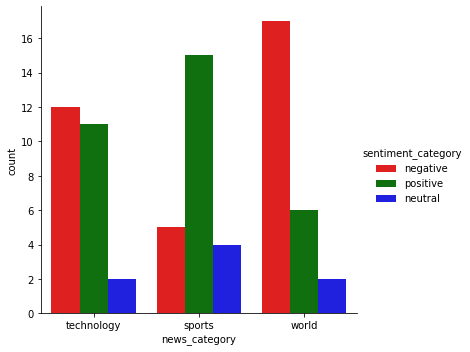

In [58]:
# frequency of sentiment labels
fc = sns.catplot(x="news_category", hue="sentiment_category", 
                 data=df, kind="count",
                 palette={'negative': 'red',
                          'positive': 'green',
                          'neutral': 'blue'})

In [84]:
print('Highest positive tech sentiment score: ', max(df[df.news_category=='technology'].sentiment_score))
print('Lowest negative tech sentiment score: ', min(df[df.news_category=='technology'].sentiment_score))

Highest positive tech sentiment score:  5.0
Lowest negative tech sentiment score:  -10.0


In [94]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 5)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -10)].index[0]

print('Highest positive tech news article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative tech news article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive tech news article: 
 Instagram has rolled out new editing features for Boomerangs, including SlowMo effect, similar to TikTok. Users can also add "Echo" blurring and "Duo" rapid rewind special effects to their Boomerangs and trim their lengths as well. While Echo helps create a 'double vision' effect, Duo affects the speed of the Boomerang and adds a 'texturised effect' at the end. 


Lowest negative tech news article: 
 Google revealed it detected and removed 1,700 malicious apps from the Play Store, which were affected by the 'Joker' malware, ever since it started tracking such apps in 2017. Such apps initially targeted users through SMS fraud but later resorted to billing fraud after new policies rolled out. Google had removed 24 apps infiltrated with 'Joker' malware in September 2019.


In [95]:
print('Highest positive sports sentiment score: ', max(df[df.news_category=='sports'].sentiment_score))
print('Lowest negative sports sentiment score: ', min(df[df.news_category=='sports'].sentiment_score))

Highest positive sports sentiment score:  24.0
Lowest negative sports sentiment score:  -4.0


In [96]:
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == 24)].index[0]
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == -4)].index[0]

print('Highest positive sports news article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative sports news article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive sports news article: 
 Pacer Jasprit Bumrah and spinner Poonam Yadav won the best male international cricketer and best female international cricketer awards respectively. Krishnamachari Srikkanth won the lifetime achievement award among male cricketers while lifetime achievement award for women went to Anjum Chopra. Mayank Agarwal and Shafali Verma won the best international debutant awards in respective categories. 


Lowest negative sports news article: 
 Ahead of the first ODI against Australia, Team India captain Virat Kohli said he is willing to change his batting position to fit in Rohit Sharma, Shikhar Dhawan and KL Rahul in playing XI. "I'd be very happy to do so. Look I am not possessive about where I play. I am not insecure about where I bat," he added.


In [97]:
print('Highest positive world news sentiment score: ', max(df[df.news_category=='world'].sentiment_score))
print('Lowest negative world news sentiment score: ', min(df[df.news_category=='world'].sentiment_score))

Highest positive world news sentiment score:  8.0
Lowest negative world news sentiment score:  -21.0


In [99]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 8)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -21)].index[0]

print('Highest positive world news article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative world news article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive world news article: 
 A driverless bullet train capable of reaching a top speed of up to 350 km/h has been launched in China. The train, which connects the Chinese cities of Beijing and Zhangjiakou, is capable of completing the 108-mile (nearly 174 km) journey in 47 minutes from the earlier three hours. The train also features 5G connectivity and smart lighting. 


Lowest negative world news article: 
 The Lahore High Court on Monday annulled former President Pervez Musharraf's death sentence, ruling that the special court which had found him guilty of treason last year was unconstitutional. The special court of Islamabad on December 17 had handed down the death penalty to 76-year-old Musharraf after six years of hearing the high-profile treason case against him.


>**Sentiment Analysis with TextBlob**

In [112]:
from textblob import TextBlob

# computer sentiment scores (polarty) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                          else 'negative' if score < 0 
                          else 'neutral' 
                          for score in sentiment_scores_tb]

# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                             \
                        count      mean       std    min      25%    50%   
news_category                                                              
sports                   24.0  0.160542  0.137433 -0.072  0.05875  0.129   
technology               25.0  0.001720  0.145647 -0.250 -0.13800  0.045   
world                    25.0  0.016040  0.141271 -0.383 -0.01100  0.009   

                              
                  75%    max  
news_category                 
sports         0.2935  0.400  
technology     0.1090  0.300  
world          0.0790  0.245

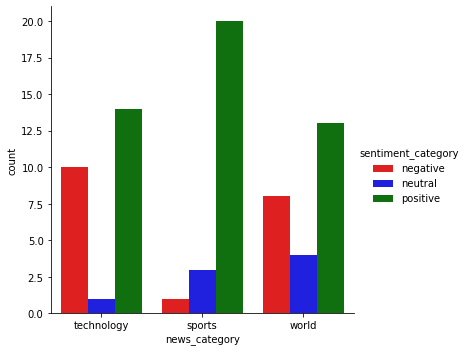

In [120]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={'negative': 'red',
                             'positive': 'green',
                             'neutral': 'blue'})

In [121]:
print('Highest positive tech sentiment score: ', max(df[df.news_category=='technology'].sentiment_score))
print('Lowest negative tech sentiment score: ', min(df[df.news_category=='technology'].sentiment_score))

Highest positive tech sentiment score:  0.3
Lowest negative tech sentiment score:  -0.25


In [122]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 0.3)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -0.25)].index[0]

print('Highest positive technology news article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative technology news article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive technology news article: 
 Electric automaker Tesla will participate in the 'Pwn2Own' hacking competition, challenging hackers to find and exploit bugs in the systems on its Model 3 vehicle. Nearly ₹7 crore and Model 3 cars will be set aside as rewards for the winners. Last year at Pwn2Own, a duo won ₹2.6 crore and Model 3 for hacking into the car's infotainment system. 


Lowest negative technology news article: 
 Electric carmaker Tesla's CEO Elon Musk has said that the company's cars will soon talk to people if the owners want. He also shared a video on Twitter where a Tesla car can be seen talking to pedestrians. The video showed Tesla's Model 3 car driving past people, saying, "Well, don't just stand there. Hop in!"


In [124]:
print('Highest positive sports sentiment score: ', max(df[df.news_category=='sports'].sentiment_score))
print('Lowest negative sports sentiment score: ', min(df[df.news_category=='sports'].sentiment_score))

Highest positive sports sentiment score:  0.4
Lowest negative sports sentiment score:  -0.072


In [126]:
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == 0.4)].index[0]
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == -0.072)].index[0]

print('Highest positive sports news article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative sports news article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive sports news article: 
 Team India pacer Jasprit Bumrah took to Instagram to share a picture of himself with trophies he won at the BCCI annual awards on Sunday. "Grateful and honoured to be taking these two awards home tonight," Bumrah captioned the picture. Commenting on the picture, former India all-rounder Yuvraj Singh wrote, "Jassi has de thoda no ones taking your trophies away!" 


Lowest negative sports news article: 
 After all-rounder Hardik Pandya was withdrawn from India A squad, a BCCI official said, "Yo-Yo Test and all he can clear in his sleep. He doesn't wish to take any half measures." This comes after reports said Hardik failed mandatory fitness tests ahead of India A's tour to New Zealand. Hardik had undergone back surgery in October last year.


In [127]:
print('Highest positive world sentiment score: ', max(df[df.news_category=='world'].sentiment_score))
print('Lowest negative world sentiment score: ', min(df[df.news_category=='world'].sentiment_score))

Highest positive world sentiment score:  0.245
Lowest negative world sentiment score:  -0.383


In [128]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.245)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.383)].index[0]

print('Highest positive world news article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative world news article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive world news article: 
 Queen Elizabeth II has accepted Prince Harry and his wife Meghan Markle's decision to step down as senior royals. "My family and I are entirely supportive of Harry and Meghan's desire to create a new life as...young family," she said. She added there would be a "transition period" during which the couple would spend time in Britain and Canada. 


Lowest negative world news article: 
 At least four Iraqi soldiers have been injured in mortar shelling targeting Al-Balad airbase housing American troops. At least eight ‘Katyusha’ rockets hit the base located around 80 km north of Baghdad, Iraqi Prime Minister's office has confirmed. There have been no reports of any casualties among the US military personnel.


>**Compare results between AFINN and TextBlob**

In [132]:
import model_evaluation_utils as meu

meu.display_confusion_matrix(true_labels=sentiment_category,
                             predicted_labels=sentiment_category_tb,
                             classes=['negative', 'neutral', 'positive'])

                 Predicted:                 
                   negative neutral positive
Actual: negative         12       5       17
        neutral           3       1        4
        positive          4       2       26


Actual is AFINN and Predicted is TextBlob